# Realization of Recursive Filters

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Cascaded Structures

The realization of recursive filters with a high order may be subject to numerical issues. For instance, when the coefficients span a wide amplitude range, their quantization may require a small quantization step or may impose a large relative error for small coefficients. The basic concept of cascaded structures is to decompose a high order filter into a cascade of lower order filters, typically first and second order recursive filters.

### Decomposition into Second-Order Sections

The rational transfer function $H(z)$ of a linear time-invariant (LTI) recursive system can be [expressed by its zeros and poles](introduction.ipynb#Transfer-Function) as

$$ H(z) = \frac{b_M}{a_N} \cdot \frac{\prod_{\mu=1}^{P} (z - z_{0\mu})^{m_\mu}}{\prod_{\nu=1}^{Q} (z - z_{\infty\nu})^{n_\nu}} $$

where $z_{0\mu}$ and $z_{\infty\nu}$ denote the $\mu$-th zero and $\nu$-th pole of degree $m_\mu$ and $n_\nu$ of $H(z)$, respectively. The total number of zeros and poles is denoted by $P$ and $Q$.

The poles and zeros of a real-valued filter $h[k] \in \mathbb{R}$ are either single real valued or conjugate complex pairs. This motivates to split the transfer function into

* first order filters constructed from a single pole and zero
* second order filters constructed from a pair of conjugated complex poles and zeros

Decomposing the transfer function into these two types by grouping the poles and zeros into single poles/zeros and conjugate complex pairs of poles/zeros results in

$$ H(z) = K \cdot \prod_{\eta=1}^{S_1} \frac{(z - z_{0\eta})}{(z - z_{\infty\eta})} 
\cdot \prod_{\eta=1}^{S_2} \frac{(z - z_{0\eta}) (z - z_{0\eta}^*)} {(z - z_{\infty\eta})(z - z_{\infty\eta}^*)} $$

where $K$ denotes a constant and $S_1 + 2 S_2 = N$ with $N$ denoting the order of the system. The cascade of two systems results in a multiplication of their transfer functions. Above decomposition represents a cascade of first- and second-order recursive systems. The former can be treated as a special case of second-order recursive systems. The decomposition is therefore known as decomposition into second-order sections (SOSs) or [biquad filters](https://en.wikipedia.org/wiki/Digital_biquad_filter). Using a cascade of SOSs the transfer function of the recursive system can be rewritten as

$$ H(z) = \prod_{\mu=1}^{S} \frac{b_{0, \mu} + b_{1, \mu} \, z^{-1} + b_{2, \mu} \, z^{-2}}{1 + a_{1, \mu} \, z^{-1} + a_{2, \mu} \, z^{-2}} $$

where $S = \lceil \frac{N}{2} \rceil$ denotes the total number of SOSs. These results state that any real valued system of order $N > 2$ can be decomposed into SOSs. This has a number of benefits

* quantization effects can be reduced by sensible grouping of poles/zeros, e.g. such that the spanned amplitude range of the filter coefficients is limited
* A SOS may be extended by a gain factor to further reduce quantization effects by normalization of the coefficients
* efficient and numerically stable SOSs serve as generic building blocks for higher-order recursive filters

### Example

The following example illustrates the decomposition of a higher-order recursive Butterworth lowpass filter into a cascade of second-order sections.

Coefficients of the recursive part
['1.00', '-5.39', '13.38', '-19.96', '19.62', '-13.14', '5.97', '-1.78', '0.31', '-0.02']


Coefficients of the recursive part of the SOSs
Section 	 a1 		 a2
0 		 -0.50953 	 0.00000
1 		 -1.04232 	 0.28838
2 		 -1.11568 	 0.37905
3 		 -1.25052 	 0.54572
4 		 -1.46818 	 0.81477


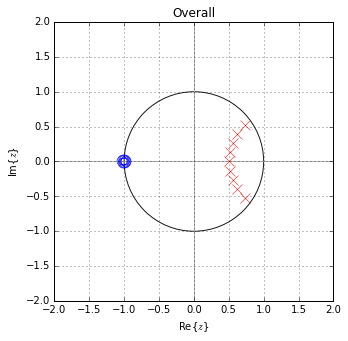

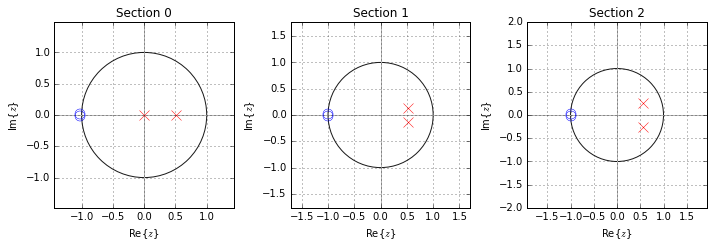

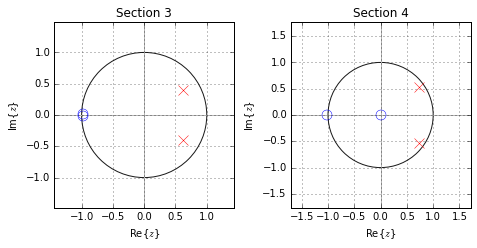

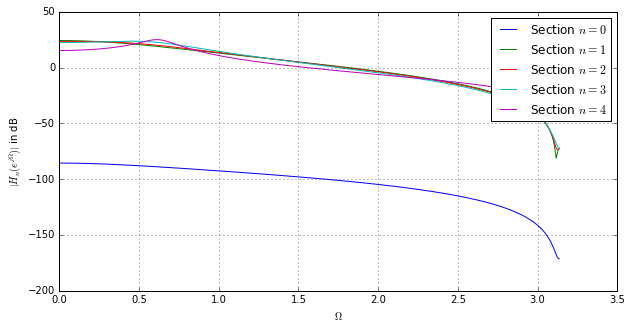

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
import scipy.signal as sig

N = 9  # order of recursive filter

def zplane(z, p):
    
    ax = plt.gca()
    plt.hold(True)

    unit_circle = Circle((0,0), radius=1, fill=False,
                         color='black', ls='solid', alpha=0.9)
    ax.add_patch(unit_circle)
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    plt.axis('equal')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid()
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms = 10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms = 10)

    plt.hold(False)


# design filter
b, a = sig.butter(N, 0.2)
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')


# print filter coefficients
print('Coefficients of the recursive part')
print(['%1.2f'%ai for ai in a])
print('\n')
print('Coefficients of the recursive part of the SOSs')
print('Section \t a1 \t\t a2')
for n in range(sos.shape[0]):
    print('%d \t\t %1.5f \t %1.5f'%(n, sos[n, 4], sos[n, 5]))

# plot poles and zeros
plt.figure(figsize=(5,5))
zplane(np.roots(b), np.roots(a))
plt.title('Overall')

for n in range(sos.shape[0]):
    if not n%3:
        plt.figure(figsize=(10, 3.5))
    plt.subplot(131+n%3)
    zplane(np.roots(sos[n, 0:3]), np.roots(sos[n, 3:6]))
    plt.title('Section %d'%n)
    plt.tight_layout()

# compute and plot frequency response of sections
plt.figure(figsize=(10,5))
for n in range(sos.shape[0]):
    Om, H = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    plt.plot(Om, 20*np.log10(np.abs(H)), label=r'Section $n=%d$'%n)
    plt.hold(True)
plt.hold(False)
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H_n(e^{j \Omega})|$ in dB')
plt.legend()
plt.grid();

**Exercise**

* What amplitude range is spanned by the filter coefficients?
* What amplitude range is spanned by the SOS coefficients?
* Change the pole/zero grouping strategy from `pairing='nearest'` to `pairing='keep_odd'`. What changes?
* Increase the order `N` of the filter. What changes?

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>